# Neural Color Transfer (Multi-Reference Style Transfer)

## Library

In [1]:
#Append 'src' direc to import modules from notebooks directory#
##################################################
#import os,sys
#src_dir=os.path.join(os.getcwd(),os.pardir)
#sys.path.append(src_dir)
#################################################

In [2]:
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import matplotlib as plt
import time
import os
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
import cv2
from torchvision import transforms
from torchvision.utils import make_grid
from collections import OrderedDict
from PIL import Image,ImageOps
import torch.optim as optim
import scipy
from skimage import color

## Input Source & Reference Image

In [4]:
USE_CUDA = True # or False if you don't have CUDA.
FEATURE_IDS = [1, 6, 11, 20, 29]

imgS_path = './image/city_basic.jpg'
imgR_path = './image/city_night.jpg'

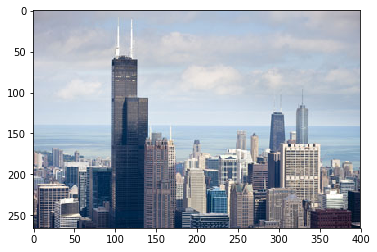

In [5]:
# Checking
origS = Image.open(imgS_path).convert("RGB")
imshow(origS)

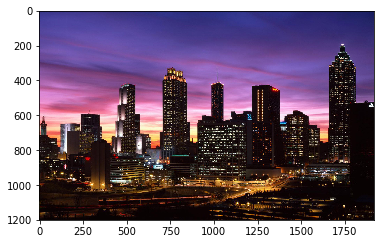

In [6]:
# Checking
origR = Image.open(imgR_path).convert("RGB")
imshow(origR)

## Image Loader

In [7]:
def image_loader(img_path, flip=False):
    img = Image.open(img_path).convert("RGB")
    if flip:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)

    data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img_tensor = data_transforms(img)
    img_tensor = img_tensor.unsqueeze(0)
    return img_tensor

def npshow(img):
    img_np = img.numpy().transpose(1, 2, 0)
    imshow(img_np) #, interpolation = 'nearest')

In [8]:
imgS=image_loader(imgS_path, flip=False)
imgR=image_loader(imgR_path, flip=False)

imgS_np = imgS.squeeze().numpy().transpose(1, 2, 0)
imgR_np = imgR.squeeze().numpy().transpose(1, 2, 0)

In [9]:
# Checking
print(imgS.size()) # (1, 3, SHeight, SWidth)
print(imgR.size()) # (1, 3, RHeight, RWidth)
print(imgS.dtype, imgR.dtype, "\n") # torch.float32

print(imgS_np.shape) # (SHeight, SWidth, 3)
print(imgR_np.shape, "\n") # (RHeight, RWidth, 3)

# Verifying normalization
print("Original S's mean:", np.asarray(origS).mean(axis=(0, 1)))
print("Original S's std:", np.asarray(origS).std(axis=(0, 1)))
print("Normalized S's mean:", imgS_np.mean(axis=(0, 1)))
print("Normalized S's std:", imgS_np.std(axis=(0, 1)), "\n")

print("Original R's mean:", np.asarray(origR).mean(axis=(0, 1)))
print("Original R's std:", np.asarray(origR).std(axis=(0, 1)))
print("Normalized R's mean:", imgR_np.mean(axis=(0, 1)))
print("Normalized R's std:", imgR_np.std(axis=(0, 1)))

torch.Size([1, 3, 266, 400])
torch.Size([1, 3, 1200, 1920])
torch.float32 torch.float32 

(266, 400, 3)
(1200, 1920, 3) 

Original S's mean: [156.07516917 164.98545113 178.04074248]
Original S's std: [60.28188864 57.59120663 53.13235746]
Normalized S's mean: [0.5548449 0.8526866 1.2986623]
Normalized S's std: [1.0323125 1.0082494 0.9260542] 

Original R's mean: [81.58577387 56.06960677 84.69521528]
Original R's std: [67.95775321 51.31118997 73.64343419]
Normalized R's mean: [-0.7207675  -1.0541035  -0.32827505]
Normalized R's std: [1.16376    0.89830506 1.2835457 ]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


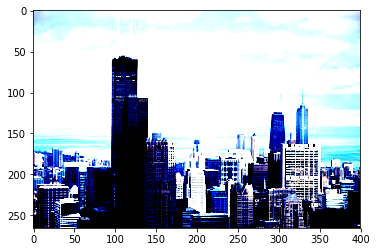

In [10]:
# Checking
imshow(imgS_np)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


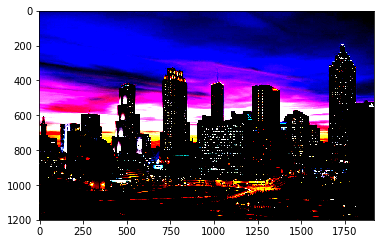

In [11]:
# Checking
imshow(imgR_np)

## Process
From S_6 = S_(L+1) to S_1(Final Result)

Feature Domain
    > FeatureExtractor
    > PatchMatch
    > BDS Voting

Image Domain
    > Resolution equal
    > Local Color Transfer

## FeatureExtractor

In [12]:
class FeatureExtractor(nn.Sequential):
    def __init__(self):
        super(FeatureExtractor, self).__init__()

    def add_layer(self, name, layer):
        self.add_module(name, layer)

    def forward(self, x, feature_id):
        for idx, module in enumerate(self._modules):
            x = self._modules[module](x)
            if idx == feature_id:
                return x

In [13]:
vgg_temp = models.vgg19(pretrained=True).features
model = FeatureExtractor()  # The new Feature extractor module network

conv_counter = 1
relu_counter = 1

block_counter = 1

for i, layer in enumerate(list(vgg_temp)):
    if isinstance(layer, nn.Conv2d):
        name = "conv_" + str(block_counter) + "_" + str(conv_counter)
        conv_counter += 1
        model.add_layer(name, layer)

    if isinstance(layer, nn.ReLU):
        name = "relu_" + str(block_counter) + "_" + str(relu_counter)
        relu_counter += 1
        model.add_layer(name, layer)

    if isinstance(layer, nn.MaxPool2d):
        name = "pool_" + str(block_counter) 
        bn_counter = relu_counter = conv_counter = 1
        block_counter += 1
        model.add_layer(name, layer)  # Is nn.AvgPool2d((2,2)) better than nn.MaxPool2d?

if USE_CUDA:
    model.cuda('cuda:3')

In [14]:
# Checking
print(model)
print([list(model._modules)[idx] for idx in FEATURE_IDS])

FeatureExtractor(
  (conv_1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1_1): ReLU(inplace)
  (conv_1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1_2): ReLU(inplace)
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2_1): ReLU(inplace)
  (conv_2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2_2): ReLU(inplace)
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_1): ReLU(inplace)
  (conv_3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_2): ReLU(inplace)
  (conv_3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_3): ReLU(inplace)
  (conv_3_4): Conv2d(256, 256, kernel_size=(

In [17]:
def get_feature(img_tensor, feature_id):
    if USE_CUDA:
        img_tensor = img_tensor.cuda('cuda:3')

    feature = model(img_tensor, feature_id)
    feature = feature.data.squeeze().cpu().numpy().transpose(1, 2, 0)
    return np.array(feature)

def normalize(feature):
    return feature / np.linalg.norm(feature, ord=2, axis=2, keepdims=True)

In [18]:
feat5S = normalize(get_feature(imgS, FEATURE_IDS[4]))
feat5R = normalize(get_feature(imgR, FEATURE_IDS[4]))

In [19]:
# Checking
print(feat5S.shape)
print(feat5R.shape)

(16, 25, 512)
(75, 120, 512)


In [20]:
# (IN PROGRESS)
# EXPERIMENTAL
class DeepDream():
    """
        Produces an image that minimizes the loss of a convolution
        operation for a specific layer and filter
    """
    def __init__(self, model, selected_layer, selected_filter, im_path):
        self.model = model
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.conv_output = 0
        self.image = image_loader(im_path, flip=False)

        if USE_CUDA:
            self.model.cuda('cuda:3')
            self.image = self.image.cuda('cuda:3')

        self.image.requires_grad_()
        # Hook the layers to get result of the convolution
        self.hook_layer()

    def hook_layer(self):
        def hook_function(module, grad_in, grad_out):
            # Gets the conv output of the selected filter (from selected layer)
            self.conv_output = grad_out[0, self.selected_filter]

        # Hook the selected layer
        self.model[self.selected_layer].register_forward_hook(hook_function)

    def dream(self):
        # Define optimizer for the image
        # Earlier layers need higher learning rates to visualize whereas lower layers need less
        optimizer = optim.SGD([self.image], lr=12, weight_decay=1e-4)
        # optimizer = optim.Adam([self.image], lr=0.1, weight_decay=1e-6)
        for i in range(1, 251):
            optimizer.zero_grad()
            # Assign image to a variable to move forward in the model
            x = self.image
            for index, layer in enumerate(self.model):
                # Forward
                x = layer(x)
                # Only need to forward until the selected layer is reached
                if index == self.selected_layer:
                    break
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            if i % 10 == 0:
                print("Iteration:", str(i) + "/250", "Loss:", "{0:.2f}".format(loss.data.cpu().numpy()))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()

Iteration: 10/250 Loss: -21.25
Iteration: 20/250 Loss: -56.55
Iteration: 30/250 Loss: -85.62
Iteration: 40/250 Loss: -110.38
Iteration: 50/250 Loss: -132.78
Iteration: 60/250 Loss: -153.31
Iteration: 70/250 Loss: -172.35
Iteration: 80/250 Loss: -190.09
Iteration: 90/250 Loss: -206.54
Iteration: 100/250 Loss: -221.93
Iteration: 110/250 Loss: -236.68
Iteration: 120/250 Loss: -250.73
Iteration: 130/250 Loss: -264.05
Iteration: 140/250 Loss: -277.05
Iteration: 150/250 Loss: -289.53
Iteration: 160/250 Loss: -301.58
Iteration: 170/250 Loss: -313.25
Iteration: 180/250 Loss: -324.68
Iteration: 190/250 Loss: -335.95
Iteration: 200/250 Loss: -346.91
Iteration: 210/250 Loss: -357.66
Iteration: 220/250 Loss: -368.27
Iteration: 230/250 Loss: -378.75
Iteration: 240/250 Loss: -389.03


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration: 250/250 Loss: -399.19


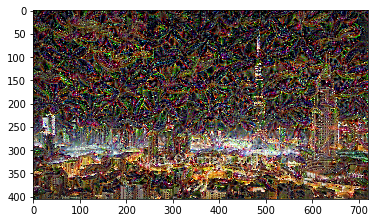

In [19]:
# (IN PROGRESS)
# EXPERIMENTAL
cnn_layer = FEATURE_IDS[4]
filter_pos = 94
dd = DeepDream(vgg_temp, cnn_layer, filter_pos, imgS_path)
# This operation can also be done without Pytorch hooks
# See layer visualisation for the implementation without hooks
dd.dream()

dd_image_np = dd.image.detach().squeeze().cpu().numpy().transpose(1, 2, 0)
imshow(dd_image_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406])

## PatchMatch

In [21]:
class PatchMatch: 
    def __init__(self, a, b, patchsize=3):
        self.a = a
        self.a_height = self.a.shape[1]    #C * H * W (e.g. 3 * 224 * 224)  == [0] * [1] * [2]
        self.a_width = self.a.shape[2]
        self.b = b
        self.b_height = self.b.shape[1]
        self.b_width = self.b.shape[2]
        self.patchsize = patchsize
        self.channels = self.a.shape[0]

        self.nnf = np.zeros((self.a.shape[1], self.a.shape[2], 2)).astype(np.int) #nnf build
        self.nnd = np.zeros((self.a.shape[1], self.a.shape[2])) #nnf distance
        self.init_nnf()

    def init_nnf(self):
        for ay in range(0, self.a_height):
            for ax in range(0, self.a_width):
                by = np.random.randint(0, self.b_height)
                bx = np.random.randint(0, self.b_width)
                self.nnf[ay, ax, :] = [by, bx]
                self.nnd[ay, ax] = self.calc_dist(ax, ay, bx, by)
    
    
    def calc_dist(self, ax, ay, bx, by, cutoff = 2147483647):
        """
        Measures distance between 2 patches across all channels
        ax -- x coordinate of patch a
        ay -- y coordinate of patch a
        bx -- x coordinate of patch b
        by -- y coordinate of patch b
        cutoff
        """
        num_pixels = 0
        pixel_sum = 0
        dmax = self.patchsize // 2  # dmax = 1
        for dy in range(-dmax, dmax + 1): #from middle pixel in patch to around pixel by -1~+1 
            for dx in range(-dmax, dmax + 1):
                pixel_exists_in_a = (ay + dy) < self.a_height and (ay + dy) >= 0 and (ax + dx) < self.a_width and (ax + dx) >= 0
                pixel_exists_in_b = (by + dy) < self.b_height and (by + dy) >= 0 and (bx + dx) < self.b_width and (bx + dx) >= 0
                if pixel_exists_in_a and pixel_exists_in_b:
                    for dc in range(0, self.channels):
                        dp_tmp = self.a[dc, ay + dy, ax + dx] - self.b[dc, by + dy, bx + dx]
                        pixel_sum += (dp_tmp * dp_tmp)
                    num_pixels += 1

        ans = pixel_sum / num_pixels
        if ans >= cutoff: return cutoff
        return ans

    def improve_guess(self, ax, ay, xbest, ybest, dbest, bx, by):
        d = self.calc_dist(ax, ay, bx, by)
        if d < dbest:
            dbest = d
            xbest = bx
            ybest = by
        return xbest, ybest, dbest

    def improve_nnf(self, total_iter=5):
        for iter in range(total_iter):
            print(iter)
            ystart, yend, ychange = 0, self.a_height, 1
            xstart, xend, xchange = 0, self.a_width, 1
            if iter % 2 == 1:
                ystart, yend, ychange = yend - 1, -1, -1
                xstart, xend, xchange = xend - 1, -1, -1
            for ay in range(ystart, yend, ychange):
                for ax in range(xstart, xend, xchange):
                    # best guess
                    ybest, xbest = self.nnf[ay, ax]
                    dbest = self.nnd[ay, ax]

                    # propagation

                    if (ax - xchange) < self.a_width and (ax - xchange) >= 0:
                        yp, xp = self.nnf[ay, ax - xchange]
                        xp += xchange
                        if xp < self.b_width and xp >= 0:
                            xbest, ybest, dbest = self.improve_guess(ax, ay, xbest, ybest, dbest, xp, yp)
                    if (ay - ychange) < self.a_height and (ay - ychange) >= 0:
                        xp, yp = self.nnf[ay - ychange, ax]
                        yp += ychange
                        if yp < self.b_height and yp >= 0:
                            xbest, ybest, dbest = self.improve_guess(ax, ay, xbest, ybest, dbest, xp, yp)

                    # random search

                    mag = max(self.b_height, self.b_width)

                    while mag >= 1:
                        ymin, ymax = max(ybest - mag, 0), min(ybest + mag, self.b_height)
                        xmin, xmax = max(xbest - mag, 0), min(xbest + mag, self.b_width)
                        yp = np.random.randint(ymin, ymax)
                        xp = np.random.randint(xmin, xmax)
                        xbest, ybest, dbest = self.improve_guess(ax, ay, xbest, ybest, dbest, xp, yp)
                        mag = mag // 2

                    self.nnf[ay, ax, :] = [ybest, xbest]
                    self.nnd[ay, ax] = dbest

    def solve(self):
        self.improve_nnf(total_iter=5)

In [22]:
snn = PatchMatch(feat5S.transpose(2, 0, 1), feat5R.transpose(2, 0, 1)) #S->R
# snn = PatchMatchTest(feat5S, feat5S, feat5R, feat5R, 3)
snn.solve()

0
1
2
3
4


In [23]:
print(snn.nnf.shape) #(14,14,2)
print(snn.nnd.shape) #(14,14)

(16, 25, 2)
(16, 25)


In [24]:
rnn = PatchMatch(feat5R.transpose(2, 0, 1), feat5S.transpose(2, 0, 1)) #R->S
rnn.solve()

0
1
2
3
4


In [25]:
print(rnn.nnf.shape) #(14,14,2)
print(rnn.nnd.shape) #(14,14)

(75, 120, 2)
(75, 120)


## BDS Voting (Reconstruct)

In [26]:
def bds_vote(snn, rnn, snnd, rnnd, src, patchsize=3):
    """
    Reconstructs an image or feature map by bidirectionaly
    similarity voting
    """

    src_height = src.shape[1]   # C * H * W
    src_width = src.shape[2]
    channels = src.shape[0]
    print("src_height: " + str(src_height))
    print("src_width: " + str(src_width))

    dest_height = snn.shape[1]
    dest_width = snn.shape[2]
    dest = np.zeros((channels, dest_height, dest_width))

    print("dest_height: " + str(dest_height))
    print("dest_width: " + str(dest_width))

    pmax = patchsize // 2

    weights = np.zeros((dest_height, dest_width))
    ws = 1 / (snn.shape[1] * snn.shape[2])  # (dest_height * dest_width)
    wr = 1 / (rnn.shape[1] * rnn.shape[2])  # (src_height * src_width)

    # coherence
    # The S->R forward NNF enforces coherence
    for i in range(dest_height):
        for j in range(dest_width):
            py = snn[0, i, j]
            px = snn[1, i, j]

            for dy in range(-pmax, pmax + 1):
                if i + dy < 0:
                    continue
                if i + dy >= dest_height:
                    break
                if py + dy < 0:
                    continue
                if py + dy >= src_height:
                    break
                for dx in range(-pmax, pmax + 1):
                    if j + dx < 0:
                        continue
                    if j + dx >= dest_width:
                        break
                    if px + dx < 0:
                        continue
                    if px + dx >= src_width:
                        break
                    for ch in range(channels):
                        dest[ch, i + dy, j + dx] += ws * src[ch, py + dy, px + dx]
                    weights[i + dy, j + dx] += ws


    # completeness
    # The R->S backward NNF enforces completeness
    for i in range(src_height):
        for j in range(src_width):
            py = rnn[0, i, j]
            px = rnn[1, i, j]

            for dy in range(-pmax, pmax + 1):
                if i + dy < 0:
                    continue
                if i + dy >= src_height:
                    break
                if py + dy < 0:
                    continue
                if py + dy >= dest_height:
                    break
                for dx in range(-pmax, pmax + 1):
                    if j + dx < 0:
                        continue
                    if j + dx >= src_width:
                        break
                    if px + dx < 0:
                        continue
                    if px + dx >= dest_width:
                        break
                    for ch in range(channels):
                        dest[ch, py + dy, px + dx] += wr * src[ch, i + dy, j + dx]
                    weights[py + dy, px + dx] += wr

    for y in range(dest_height):
        for x in range(dest_width):
            s = 1 if weights[y, x] == 0 else (1 / weights[y, x])
            for ch in range(channels):
                dest[ch, y, x] *= s

    return dest

In [28]:
#(512 14 14)  imgR = 3 224 224    reR = 512 14 14
def image_to_tensor(img, img_transforms = []):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    transform = transforms.Compose(img_transforms + [
        transforms.ToTensor(),

    ])
    return transform(img)

def resized_R(self, size):
        return image_to_tensor(origR, [transforms.Resize(size)])
def resized_S(self,size):
        return image_to_tensor(origS,[transforms.Resize(size)])

Rs_R = resized_R(origR, feat5R.shape[:2])

print(Rs_R)

tensor([[[0.2196, 0.2196, 0.2235,  ..., 0.1059, 0.1020, 0.0941],
         [0.2392, 0.2392, 0.2431,  ..., 0.1098, 0.1059, 0.1020],
         [0.2588, 0.2588, 0.2627,  ..., 0.1216, 0.1176, 0.1098],
         ...,
         [0.3059, 0.2784, 0.1333,  ..., 0.0902, 0.1255, 0.0863],
         [0.2353, 0.1765, 0.0824,  ..., 0.0588, 0.0980, 0.0588],
         [0.0902, 0.0667, 0.0471,  ..., 0.0471, 0.0627, 0.0353]],

        [[0.2118, 0.2118, 0.2118,  ..., 0.1255, 0.1176, 0.1137],
         [0.2235, 0.2275, 0.2275,  ..., 0.1255, 0.1176, 0.1137],
         [0.2392, 0.2392, 0.2431,  ..., 0.1294, 0.1255, 0.1255],
         ...,
         [0.1765, 0.1608, 0.0745,  ..., 0.0431, 0.0706, 0.0353],
         [0.1216, 0.0863, 0.0353,  ..., 0.0196, 0.0510, 0.0275],
         [0.0314, 0.0196, 0.0078,  ..., 0.0118, 0.0235, 0.0118]],

        [[0.5412, 0.5412, 0.5451,  ..., 0.3922, 0.3843, 0.3725],
         [0.5647, 0.5647, 0.5686,  ..., 0.3922, 0.3804, 0.3765],
         [0.5922, 0.5922, 0.5961,  ..., 0.3922, 0.3843, 0.

In [ ]:
Rs_R.shape()

TypeError: 'torch.Size' object is not callable

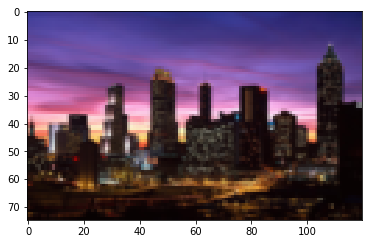

In [30]:
npshow(Rs_R)

In [31]:
Rs_S = resized_S(origS, feat5S.shape[:2])

print(Rs_S)

tensor([[[0.6510, 0.6627, 0.6667,  ..., 0.7333, 0.7137, 0.6863],
         [0.6745, 0.6784, 0.6902,  ..., 0.7176, 0.7137, 0.6784],
         [0.7137, 0.7255, 0.7529,  ..., 0.7569, 0.7216, 0.6824],
         ...,
         [0.4392, 0.4588, 0.5216,  ..., 0.6667, 0.6078, 0.2392],
         [0.3529, 0.4196, 0.4784,  ..., 0.4667, 0.4431, 0.1176],
         [0.2784, 0.3294, 0.5294,  ..., 0.2275, 0.2039, 0.1412]],

        [[0.6588, 0.6784, 0.6863,  ..., 0.7333, 0.7137, 0.6824],
         [0.6902, 0.6980, 0.7137,  ..., 0.7333, 0.7255, 0.6941],
         [0.7294, 0.7412, 0.7608,  ..., 0.7647, 0.7412, 0.7098],
         ...,
         [0.4314, 0.4588, 0.5294,  ..., 0.6588, 0.6235, 0.2902],
         [0.3529, 0.4235, 0.4863,  ..., 0.4471, 0.4353, 0.1569],
         [0.2902, 0.3490, 0.5373,  ..., 0.1647, 0.1451, 0.1412]],

        [[0.7176, 0.7412, 0.7529,  ..., 0.7647, 0.7451, 0.7176],
         [0.7569, 0.7686, 0.7765,  ..., 0.7804, 0.7686, 0.7490],
         [0.7843, 0.7882, 0.7961,  ..., 0.8000, 0.7882, 0.

In [32]:
Rs_S.size()

torch.Size([3, 16, 25])

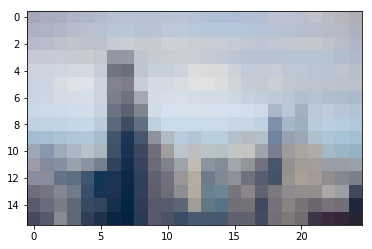

In [33]:
npshow(Rs_S)

In [34]:
G = bds_vote(snn.nnf.transpose(2, 0, 1), rnn.nnf.transpose(2, 0, 1), snn.nnd, rnn.nnd, Rs_R)
print(G)

src_height: 75
src_width: 120
dest_height: 16
dest_width: 25
[[[0.29167634 0.32712034 0.44112634 ... 0.41837228 0.36556247 0.35604506]
  [0.33049774 0.36711188 0.48065779 ... 0.48685067 0.41792283 0.39273389]
  [0.39068733 0.43651857 0.54839644 ... 0.53529726 0.45138708 0.41834446]
  ...
  [0.19235551 0.2082909  0.21606984 ... 0.26841303 0.24585029 0.26047772]
  [0.16806401 0.19641145 0.20778338 ... 0.2679164  0.2874577  0.29187108]
  [0.18500646 0.18246881 0.1763452  ... 0.19350867 0.23173538 0.25958333]]

 [[0.22392158 0.24609254 0.31067849 ... 0.28958725 0.25747842 0.25132249]
  [0.2398515  0.25987392 0.31505567 ... 0.31034291 0.27863983 0.26542715]
  [0.27181426 0.29754609 0.34679843 ... 0.32158114 0.2887312  0.27777442]
  ...
  [0.12800205 0.14423697 0.15316602 ... 0.17819112 0.16259958 0.16268806]
  [0.11924724 0.15095456 0.17027078 ... 0.17080131 0.19398073 0.20146861]
  [0.13696137 0.13875223 0.14481304 ... 0.11217292 0.13653698 0.15535539]]

 [[0.49007459 0.52257339 0.59150515

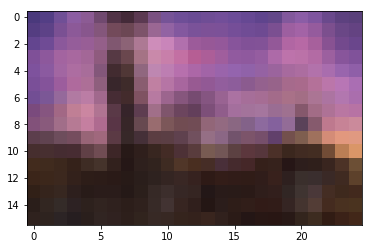

In [35]:
imshow(np.transpose(G,(1,2,0)))

## 오늘은 여기까지

## Affine Transfrom

In [38]:
###example of rgb2lab but can't use in here bacause different initilization process.
origSnp = np.asarray(origS)/255 ##0~255를 0~1로 만든다 rgb2lab엔 range detection이 없어서
origS_lab = color.rgb2lab(origSnp)
origS_lab

array([[[ 68.22041515,   3.09829757,  -7.06738869],
        [ 68.22041515,   3.09829757,  -7.06738869],
        [ 68.22041515,   3.09829757,  -7.06738869],
        ..., 
        [ 71.68514622,   3.08095938,  -2.93812813],
        [ 71.68514622,   3.08095938,  -2.93812813],
        [ 71.31505123,   3.08425348,  -2.9411943 ]],

       [[ 67.84661992,   3.10224993,  -7.07511646],
        [ 67.84661992,   3.10224993,  -7.07511646],
        [ 67.84661992,   3.10224993,  -7.07511646],
        ..., 
        [ 70.94456415,   3.08756869,  -2.94427955],
        [ 70.57368246,   3.09090524,  -2.9473841 ],
        [ 70.57368246,   3.09090524,  -2.9473841 ]],

       [[ 67.84661992,   3.10224993,  -7.07511646],
        [ 67.84661992,   3.10224993,  -7.07511646],
        [ 67.84661992,   3.10224993,  -7.07511646],
        ..., 
        [ 69.62476451,   4.02949357,  -4.36347497],
        [ 69.62476451,   4.02949357,  -4.36347497],
        [ 69.25249493,   4.03396516,  -4.36813823]],

       ..., 
   

In [39]:
origSnp.shape

(266, 400, 3)

In [40]:
npRss = np.asarray(Rs_S)
npRss = np.transpose(npRss,(2,1,0))
labRss = color.rgb2lab(npRss)
labRss.shape #14 14 3

(14, 14, 3)

In [41]:
npG = np.asarray(G)
npG = np.transpose(npG,(2,1,0))
labG = color.rgb2lab(npG)
labG.shape #14 14 3
labGl,labGa, labGb = labG[: , : ,0],labG[: , : , 1], labG[: , : , 2]
labGl #14 14

array([[ 28.3189197 ,  22.3451206 ,  22.21471056,  36.17647112,
         46.6826316 ,   9.4822914 ,   2.13635527,  10.87685169,
          4.20476523,  53.48240037,  42.78668604,  11.42375244,
          9.95016701,   8.66603833],
       [ 40.19780228,  40.19780228,  53.48240037,  53.48240037,
         42.78668604,  42.78668604,  30.59954942,  17.30280965,
         17.82826658,  10.87685169,   4.20476523,  12.45399308,
         10.4925422 ,  35.17200855],
       [ 38.81321411,  38.81321411,  43.53921885,  43.53921885,
         22.3451206 ,  22.3451206 ,  22.21471056,  15.41548292,
         13.15293419,  11.03201808,   4.93258932,  41.03982463,
         45.78148313,  33.58269694],
       [ 38.81321411,  38.81321411,  43.52335557,  38.74824812,
         22.3451206 ,  22.3451206 ,  22.21471056,  22.21471056,
         17.30280965,  12.79793461,  35.61869147,  13.54728854,
          6.16581553,  35.61869147],
       [ 52.48158147,  52.48158147,  49.86777743,  50.42641869,
         28.92044013

In [42]:
meanGl = np.zeros((12,12))
sumGl =np.zeros((12,12))
stdGl = np.zeros((12,12))

#make patch
#patch -> mean, std
for gy in range (1,12):
    for gx in range (1,12):
        meanGl[gy,gx] = (labGl[gy,gx]+labGl[gy-1,gx]+labGl[gy+1,gx]
                         +labGl[gy,gx-1]+labGl[gy-1,gx-1]+labGl[gy+1,gx-1]
                         +labGl[gy,gx+1]+labGl[gy-1,gx+1]+labGl[gy+1,gx+1])/9
        stdGl[gy,gx] = (labGl[gy,gx]-meanGl[gy,gx]+labGl[gy-1,gx]+labGl[gy+1,gx]
                         +labGl[gy,gx-1]+labGl[gy-1,gx-1]+labGl[gy+1,gx-1]
                         +labGl[gy,gx+1]+labGl[gy-1,gx+1]+labGl[gy+1,gx+1])

meanGl #12 12

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,  36.43582254,  39.3100619 ,  40.47209537,
         35.51406963,  26.81990573,  19.23998417,  14.85908061,
         17.13026449,  18.05569741,  21.35920899,  20.34064479],
       [  0.        ,  41.79927065,  43.79323029,  40.42130771,
         34.52485798,  27.77586945,  24.15987788,  19.80510935,
         15.32486866,  14.19409565,  16.27821741,  19.3596659 ],
       [  0.        ,  44.12737458,  44.41691636,  38.13943543,
         31.24786114,  22.961055  ,  20.48580183,  16.32748239,
         13.60787085,  16.66172262,  21.44756734,  24.68845888],
       [  0.        ,  45.04879409,  43.91772929,  37.37834801,
         33.66857913,  25.99332848,  25.41365806,  21.72931801,
         19.21777528,  21.13392184,  25.0658265 ,  25.92830182],
       [  0.        ,  38.65991256,

In [43]:
##in patch, need to calculate a,b from (pixel p and nearby 8pixel = q)
class LocalColorTransfer:
    def __init__(self, source, guide, patchsize=3):
        self.s = source
        self.s_height = self.source.shape[1]    #C * H * W (e.g. 3 * 14* 14)  == [0] * [1] * [2]
        self.s_width = self.source.shape[2]
        self.g = guide
        self.g_height = self.guide.shape[1]
        self.g_width = self.guide.shape[2]
        self.patchsize = patchsize
        self.channels = self.source.shape[0]

        self.sew = self.source.shape[2] - self.patchsize + 1 #number of patch that can be made in width
        self.seh = self.source.shape[1] - self.patchsize + 1 #number of patch that can be made in height
        self.gew = self.guide.shape[2] - self.patchsize + 1
        self.geh = self.guide.shape[1] - self.patchsize + 1
        self.patchlab()
    
    def patchlab(self): ##initialize a and b from source and guidance by lab space using mean and std
        for sy in range (1, self.seh):
            for sx in range (1,self.sew):
            
        

SyntaxError: unexpected EOF while parsing (<ipython-input-43-2491c096927f>, line 23)